In [1]:
# import packages
import os
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np  
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

plt.rcParams['font.sans-serif'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False 

In [2]:
directory = os.getcwd()
filename = "GumWeight_20230101_20241015.xlsx"
file_path = os.path.join(directory, 'input', filename)

In [96]:
raw = pd.read_excel(file_path)
sku_full_list = set(raw['Item'])
raw['Item'] = raw['Item'].str[:4].str.replace('（', '')
sku_list = [
    'DMPE',
    # 'DMPY'
    ]
# spc_data = spc_data[spc_data['Item'].isin(sku_list)]

# Define the function to format the datetime columns in a DataFrame
def format_datetime_columns(df, column_names):
    for column in column_names:
        # Convert to datetime, handle mixed formats, and remove timezone information
        df[column] = pd.to_datetime(df[column], utc=True).dt.tz_localize(None)
        df[column] = df[column].dt.floor('s')
    return df

# format TS
raw = format_datetime_columns(raw, ['Date'])
key_cols = ['Date', 'Item', 'Operator', 'Shift', 'Actual']
raw = raw[key_cols]


raw['Actual'] = raw['Actual'].apply(lambda x: x / 2 if x > 60 else x)
raw['Actual_per_slide'] = raw['Actual'].apply(lambda x: x / 13)
raw['result'] = raw['Actual'].apply(lambda x: 'over' if x > 35.36 else 'less' if x < 35.1 else 'normal')
spc_data = raw[raw['Date'] > pd.Timestamp('2024-05-08 00:00:00')]

In [97]:
start_dt = spc_data['Date'].min().strftime('%Y%m%d')
end_dt = spc_data['Date'].max().strftime('%Y%m%d')
print(f'{start_dt}-{end_dt}')
print(sku_full_list)

20240508-20241015
{'EBB（益达蓝莓-NCS）', 'DMRJ（茉莉薄荷）', 'DMPE 绿箭原味薄荷', 'WSP（白箭留兰香薄荷）', 'FVWM（FIVE奔涌西瓜-NCS）', 'EXSM（益达沁凉薄荷-NCS）', 'DMRC（绿箭樱花薄荷）', nan, 'DMLG（柠檬草薄荷）', 'EXCW（益达西瓜-NCS）', 'DMPY（绿箭金装薄荷）', 'EXTP（益达热带水果-NCS）', 'RPSY（维能劲爆麻辣）', 'FVBB（FIVE魅幻蓝莓-NCS）', 'RPCM（维能酷爽薄荷）', 'DMRR（真叶玫瑰薄荷）', 'RPWP（维能西瓜红石榴）', 'EXPP（益达冰凉薄荷味）', 'AUWM（澳洲FIVE奔涌西瓜味）', 'FVSS（FIVE酷酸草莓味-NCS）', 'DMRM（真叶薄荷）', 'FVPP（FIVE激酷薄荷味-NCS）', 'DMLM（绿箭青柠薄荷）'}


#### Value Tracking

In [9]:
def calculate_cpk(data, usl, lsl):
    # Calculate mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # ddof=1 for sample standard deviation
    # std_dev = 0.1*13/6
    print(f'口香糖单片均重 {mean/13:.4f}g，标准差 {std_dev:.3f}')
    
    # Calculate CPU and CPL
    cp = (usl - lsl) / (6 * std_dev)
    cpu = (usl - mean) / (3 * std_dev)
    cpl = (mean - lsl) / (3 * std_dev)
    cpk = min(cpu, cpl)
    print(f'整体CP {cp:.3f}，CPK {cpk:.3f}')

    mean_per_slice = mean/13
    # mean = 2.71 # ideal value
    sugar_saving = (2.73-mean_per_slice)/2.73*7864.6*18.14
    sugarfree_saving = (2.73-mean_per_slice)/2.73*5489.4*20.73
    usdcny = 7.2083
    value_saving = (sugar_saving+sugarfree_saving) / usdcny

    print(f'Annual value saving forecast is around ${value_saving:.3f}k') # target 261k

    return mean, std_dev, cpk, value_saving

# Test the function with example data
# usl, lsl = 2.73*13, 2.70*13
usl, lsl = 2.80*13, 2.70*13
spc_mean, spc_std_dev, spc_cpk, value_saving= calculate_cpk(spc_data['Actual'], usl, lsl)

usl, lsl = 2.80, 2.70
spc_mean, spc_std_dev, spc_cpk, value_saving= calculate_cpk(spc_data['Actual_per_slide'], usl, lsl)

口香糖单片均重 2.7161g，标准差 0.225
整体CP 0.961，CPK 0.309
Annual value saving forecast is around $181.689k
口香糖单片均重 0.2089g，标准差 0.017
整体CP 0.961，CPK 0.309
Annual value saving forecast is around $32855.490k


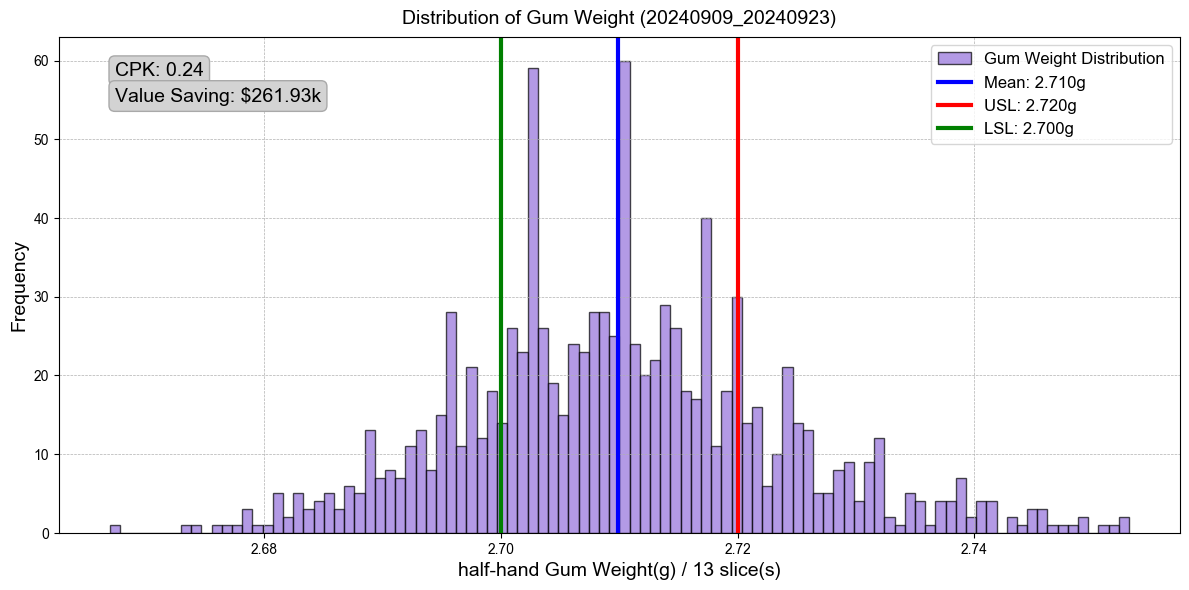

In [42]:
slice_no = 13

colors = {
    'hist_color': '#9370DB',  # purple
    'mean_color': '#0000FF',  # blue
    'usl_color': '#FF0000',  # red
    'lsl_color': '#008000',  # green
    'text_bg_color': '#D3D3D3',  # light grey
    'text_edge_color': '#A9A9A9'  # dark grey
}

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.hist(spc_data['Actual']/slice_no, bins=100, edgecolor='black', alpha=0.7, color=colors['hist_color'], label='Gum Weight Distribution')

# Plot mean, USL, and LSL
plt.axvline(spc_mean/slice_no, color=colors['mean_color'], linestyle='-', linewidth=3, label=f'Mean: {spc_mean/slice_no:.3f}g')
plt.axvline(usl/slice_no, color=colors['usl_color'], linestyle='-', linewidth=3, label=f'USL: {usl/slice_no:.3f}g')
plt.axvline(lsl/slice_no, color=colors['lsl_color'], linestyle='-', linewidth=3, label=f'LSL: {lsl/slice_no:.3f}g')

# Add title with date range and smaller font size
plt.title(f'Distribution of Gum Weight ({start_dt}_{end_dt})', fontsize=14, fontweight='bold', y=1.01)

# Add labels
plt.xlabel(f'half-hand Gum Weight(g) / {slice_no} slice(s)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add legend
plt.legend(frameon=True, fontsize=12)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Annotate CPK and value saving
plt.text(0.05, 0.95, f'CPK: {spc_cpk:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['text_bg_color'], edgecolor=colors['text_edge_color']))
plt.text(0.05, 0.90, f'Value Saving: ${value_saving:.2f}k', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['text_bg_color'], edgecolor=colors['text_edge_color']))

plt.tight_layout()
plt.show()

#### Calculating estimated CpK

In [18]:
from scipy.stats import norm

# Given data
usl, lsl = 2.72*13, 2.70*13
target = 2.71 * 13  # Target mean weight
percentile = 0.90  # 90% of the data  =0.9973 for CpK=1

# For 90% of the data to fall within [2.70, 2.72], we need to find the z-scores
# that correspond to the 5th percentile (lower end) and 95th percentile (upper end)
z_lower = norm.ppf((1 - percentile) / 2)
z_upper = norm.ppf(1 - (1 - percentile) / 2)

# The distance from the mean to each specification limit is proportional to the standard deviation (sigma)
# We use the lower z-score because it's more conservative (smaller sigma)
distance = (target - lsl)
sigma = distance / z_upper
variance = sigma**2

# Calculate CPU and CPL
cpu = (usl - target) / (3 * sigma)
cpl = (target - lsl) / (3 * sigma)
cpk = min(cpu, cpl)
print(f'Overall, we have a CPK of {cpk:.3f}')
print(f'Overall, we have a Variance of {variance:.3f}')
print(f'Overall, we have a Sigma of {sigma:.3f}')

Overall, we have a CPK of 0.548
Overall, we have a Variance of 0.006
Overall, we have a Sigma of 0.079


#### Measurement tracking

In [111]:
spc_2023 = raw[raw['Date'] < pd.Timestamp('2024-01-01 00:00:00')]
spc_2024 = raw[raw['Date'] > pd.Timestamp('2024-01-01 00:00:00')]
spc_202409_202410 = raw[raw['Date'] > pd.Timestamp('2024-09-01 00:00:00')]

spc = spc_202409_202410
start_dt = spc['Date'].min().strftime('%Y%m%d')
end_dt = spc['Date'].max().strftime('%Y%m%d')
spc['time_delta_last'] = spc['Date'] - spc['Date'].shift(1)

# create group number
spc['group'] = 1
sec = 15
mask = spc['time_delta_last'] > pd.Timedelta(seconds=sec)
#spc['time_delta_last'].describe()
group_increment = mask.cumsum()
spc['group'] += group_increment

spc.groupby('group').size()

group
1       2
2       2
3       2
4       2
5       2
       ..
2653    2
2654    2
2655    2
2656    2
2657    3
Length: 2657, dtype: int64

In [112]:
# 看同一个group里面有超过1次以上spc称重的case
df_grouped_double_count = spc.groupby('group').filter(lambda x: len(x) > 1)
spc_filtered = spc[spc.index.isin(df_grouped_double_count.index)]
spc_filtered.to_excel(f'output/spc_over_once_in_{sec}s_{start_dt}_{end_dt}.xlsx')

# 看同一个group里面即有超重也有偏轻的case
df_grouped_double_count_bad_case = spc_filtered.groupby('group')['result'].agg(lambda x: set(x)).reset_index()
df_grouped_double_count_bad_case = df_grouped_double_count_bad_case[df_grouped_double_count_bad_case['result'].apply(lambda x: 'over' in x and 'less' in x)]
spc_bad_case = spc_filtered[spc_filtered['group'].isin(df_grouped_double_count_bad_case['group'])]

In [114]:
spc_bad_case.tail(50)

,Date,Item,Operator,Shift,Actual,Actual_per_slide,result,time_delta_last,group
66610,2024-10-11 11:02:26,FVBB,王高伟,早班,36.09,2.776154,over,0 days 00:00:05,2286
66611,2024-10-11 11:02:29,FVBB,王高伟,早班,34.79,2.676154,less,0 days 00:00:03,2286
66612,2024-10-11 11:02:31,FVBB,王高伟,早班,35.21,2.708462,normal,0 days 00:00:02,2286
66613,2024-10-11 11:02:36,FVBB,王高伟,早班,35.15,2.703846,normal,0 days 00:00:05,2286
66636,2024-10-11 12:36:53,FVBB,王高伟,早班,35.38,2.721538,over,0 days 00:09:21,2296
66637,2024-10-11 12:36:56,FVBB,王高伟,早班,35.41,2.723846,over,0 days 00:00:03,2296
66638,2024-10-11 12:37:01,FVBB,王高伟,早班,35.03,2.694615,less,0 days 00:00:05,2296
66639,2024-10-11 12:42:03,FVBB,王高伟,早班,35.55,2.734615,over,0 days 00:05:02,2297
66640,2024-10-11 12:42:07,FVBB,王高伟,早班,35.07,2.697692,less,0 days 00:00:04,2297
66641,2024-10-11 12:42:10,FVBB,王高伟,早班,35.24,2.710769,normal,0 days 00:00:03,2297


In [118]:
# 连着10次测量不超过15s间隔 group 3250
# bad case group 245,20172
# spc_bad_case.tail(50)
spc_filtered[spc_filtered['group'] == 2634]

,Date,Item,Operator,Shift,Actual,Actual_per_slide,result,time_delta_last,group
67330,2024-10-15 07:52:23,DMPE,钱泽朋,晚班,35.41,2.723846,over,0 days 00:08:26,2634
67331,2024-10-15 07:52:27,DMPE,钱泽朋,晚班,35.58,2.736923,over,0 days 00:00:04,2634
67332,2024-10-15 07:52:38,DMPE,钱泽朋,晚班,35.44,2.726154,over,0 days 00:00:11,2634
67333,2024-10-15 07:52:43,DMPE,钱泽朋,晚班,35.09,2.699231,less,0 days 00:00:05,2634
67334,2024-10-15 07:52:46,DMPE,钱泽朋,晚班,35.09,2.699231,less,0 days 00:00:03,2634
67335,2024-10-15 07:52:52,DMPE,钱泽朋,晚班,34.98,2.690769,less,0 days 00:00:06,2634
67336,2024-10-15 07:52:57,DMPE,钱泽朋,晚班,35.08,2.698462,less,0 days 00:00:05,2634
67337,2024-10-15 07:53:02,DMPE,钱泽朋,晚班,35.25,2.711538,normal,0 days 00:00:05,2634


In [116]:
bad_case_count = len(set(spc_bad_case['group']))
over_once_count = len(set(spc_filtered['group']))
overall_count = len(set(spc['group']))

print(f'------- SPC数据范围 {start_dt}-{end_dt} -------')
print(f'{sec}秒内SPC称重即有超重还有偏轻的概率：{bad_case_count/over_once_count*100:.2f}%')
print(f'{sec}秒内超过1次以上SPC称重的概率：{over_once_count/overall_count*100:.2f}%')

------- SPC数据范围 20240903-20241015 -------
15秒内SPC称重即有超重还有偏轻的概率：6.80%
15秒内超过1次以上SPC称重的概率：87.96%


In [117]:
group_sizes = spc_filtered.groupby('group').size()
# group_sizes = spc_bad_case.groupby('group').size()
group_size_counts = group_sizes.value_counts().sort_index()
group_size_counts

2     1911
3      254
4      111
5       36
6       16
7        5
8        2
10       2
Name: count, dtype: int64